# Monotonic Classifiers
Brief description
## Imports and Definitions

In [196]:
import os
import sys
import fnmatch
import random
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

## utils
def rwalk(directory, pattern):
    """Recursively search "directory" for files that match the Unix shell-style
    wildcard given by "pattern" (like '*.mp3'). Returns matches as a generator."""
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            yield os.path.join(root, filename)

def gettraces(benignpath='../data/01-monotonic-classifiers/benign-traces',
              malpath='../data/01-monotonic-classifiers/malicious-traces'):
    return list(rwalk(malpath, '*.trace')), list(rwalk(benignpath, '*.trace'))

def get_random_malicious_trace(malpath='../data/01-monotonic-classifiers/malicious-traces'):
    mal, _ = gettraces(malpath=malpath)
    with open(random.choice(mal)) as f:
        return f.read()

def vectorize(featurename,
              featuredir='../data/01-monotonic-classifiers/feature-vectors'):
    pos_traces, neg_traces = gettraces()
    pos_y = [1 for _ in pos_traces]
    neg_y = [0 for _ in neg_traces]
    docs = [open(x).read() for x in pos_traces + neg_traces]
    y = np.array(pos_y + neg_y)
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(docs)
    terms = np.asarray(vectorizer.get_feature_names())
    # Save feature vectors and metadata
    with open(os.path.join(featuredir, featurename), 'wb') as f:
        np.savez(f, X=X, y=y, terms=terms, vectorizer=vectorizer)
    return X, y, terms, vectorizer

X, y, terms, vectorizer = vectorize('foo.npz')

In [197]:
X

<2000x16 sparse matrix of type '<class 'numpy.float64'>'
	with 32000 stored elements in Compressed Sparse Row format>

In [73]:
terms

array(['ntcreateprocessex', 'ntcreatethreadex', 'ntcreateuserprocess',
       'ntdisplaystring', 'ntdrawtext', 'ntmodifybootentry', 'ntopenfile',
       'ntopenkeyex', 'ntopentimer', 'ntquerydirectoryfile', 'ntreadfile',
       'ntsavekeyex', 'ntsettimerex', 'ntwritefile', 'regcreatekeyex',
       'regsavekeyex'],
      dtype='<U20')

In [198]:
def savemodel(clf, modeldir, name, csvname):
    date = csvname.split('-')[0]
    modelname = '%s.model' % csvname.replace('.csv', '')
    modeldir = os.path.join(modeldir, name)
    modelpath = os.path.join(modeldir, modelname)
    try:
        os.mkdir(modeldir)
    except OSError:
        pass
    joblib.dump(clf, modelpath)
    sys.stderr.write('Model saved to %s\n' % os.path.join(modeldir, modelname))

def _heatmap(crosstab):
    plt.clf()
    p = seaborn.heatmap(crosstab, square=True)
    plt.tight_layout()
    plt.show()

def _cv(X, y, k, name, clf, csvname, modeldir=None, terms=None, resultdir=None):
    print('## %s' % name)
    print('### Cross Validation')
    print('`%s`' % str(cross_val_score(clf, X, y, cv=k)))
    print('### CV Confusion Matrix')
    y_pred = cross_val_predict(clf, X, y, cv=k)
    print('```')
    print(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted']))
    print('```')

    if resultdir:
        heatmapdir = os.path.join(resultdir, csvname.replace('.csv', ''))
        try:
            os.mkdir(heatmapdir)
        except OSError:
            pass
        _heatmap(pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'],
                             normalize='index'))

    if modeldir:
        clf.fit(X, y)
        savemodel(clf, modeldir, name, csvname)

        if hasattr(clf, 'coef_') and terms is not None:
            print("### Top 10 keywords per class:")
            #for i, category in enumerate(clf.classes_):
                #top10 = np.argsort(clf.coef_[i])[-10:]
                #print("* %s: `%s`" % (category, ", ".join(terms[top10])))
            print('')
            
    return clf

## name
### Cross Validation
`[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]`
### CV Confusion Matrix
```
Predicted     0     1
True                 
0          1000     0
1             0  1000
```


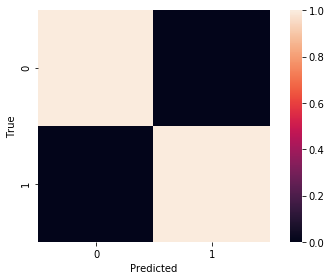

Model saved to ../work/name/foo.model


### Top 10 keywords per class:

## name
### Cross Validation
`[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]`
### CV Confusion Matrix
```
Predicted  0.444444  0.555556
True                         
0                 0      1000
1              1000         0
```


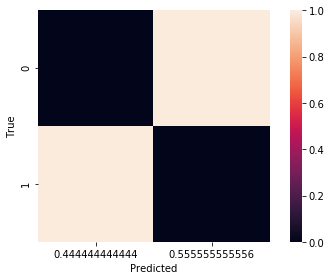

### Top 10 keywords per class:



Model saved to ../work/name/foo.model


In [192]:
clf = _cv(X, y, 10, 'name', LogisticRegression(solver='lbfgs'), 'foo.csv', modeldir='../work', terms=terms, resultdir='../work')
adv_clf = _cv(X, y, 10, 'name', Lasso(), 'foo.csv', modeldir='../work', terms=terms, resultdir='../work')

In [94]:
clf.classes_

array([0, 1])

In [101]:
clf.coef_[0]

array([ 2.24482262,  2.24424061, -2.14186277, -2.13967196, -2.1405273 ,
        2.24523331, -2.13965475, -2.13854639, -2.13845327, -2.1407568 ,
       -2.14462209,  2.24613296,  2.24276795,  0.10771154,  2.24801507,
        2.2431061 ])

In [98]:
terms

array(['ntcreateprocessex', 'ntcreatethreadex', 'ntcreateuserprocess',
       'ntdisplaystring', 'ntdrawtext', 'ntmodifybootentry', 'ntopenfile',
       'ntopenkeyex', 'ntopentimer', 'ntquerydirectoryfile', 'ntreadfile',
       'ntsavekeyex', 'ntsettimerex', 'ntwritefile', 'regcreatekeyex',
       'regsavekeyex'],
      dtype='<U20')

In [116]:
# to solutions
list(zip(clf.coef_[0], terms))

[(2.244822624665078, 'ntcreateprocessex'),
 (2.2442406107176378, 'ntcreatethreadex'),
 (-2.1418627669686781, 'ntcreateuserprocess'),
 (-2.139671958251073, 'ntdisplaystring'),
 (-2.1405272962289352, 'ntdrawtext'),
 (2.2452333134082001, 'ntmodifybootentry'),
 (-2.1396547495478839, 'ntopenfile'),
 (-2.1385463916610488, 'ntopenkeyex'),
 (-2.1384532744136902, 'ntopentimer'),
 (-2.140756798461291, 'ntquerydirectoryfile'),
 (-2.1446220879737208, 'ntreadfile'),
 (2.2461329578438169, 'ntsavekeyex'),
 (2.2427679460606038, 'ntsettimerex'),
 (0.1077115444337042, 'ntwritefile'),
 (2.2480150712142422, 'regcreatekeyex'),
 (2.2431060978323192, 'regsavekeyex')]

In [119]:
adv_clf.coef_

array([ 0.,  0., -0., -0., -0.,  0., -0., -0., -0., -0., -0.,  0.,  0.,
        0.,  0.,  0.])

In [131]:
foo = get_random_malicious_trace()

In [174]:
v1 = vectorizer.transform([foo])
v2 = vectorizer.transform([foo + '\n' + '\n'.join(itertools.repeat('ntdisplaystring', 17759))])

In [175]:
v1

<1x16 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [176]:
v2

<1x16 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [177]:
clf.predict(v1)

array([1])

In [178]:
clf.predict(v2)

array([0])

In [179]:
len(foo.split())

17759

In [181]:
# to solutions?
def gen_adversarial_sample(path):
    with open(path) as f:
        s = f.read()
        numsyscalls = len(s.split())
        s_benign = s + '\n' + '\n'.join(itertools.repeat('ntdisplaystring', numsyscalls))
        return s, s_benign

In [182]:
s, s_benign = gen_adversarial_sample('../data/01-monotonic-classifiers/malicious-traces/0999.trace')
print(len(s))
print(len(s_benign))

186656
390128


In [191]:
# she works!
clf.predict(vectorizer.transform([s, s_benign]))

array([1, 0])

In [188]:
foo[:10]

'NtCreateTh'